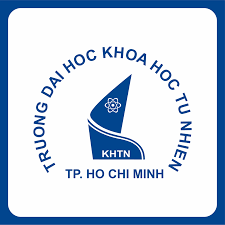                                                      


---
<div style="text-align:center">
    <h1> 
       Project 01 : DATA COLLECTION & EDA
    </h1> 
</div>


<div style="text-align:right">
    VIETNAM NATIONAL UNIVERSITY UNIVERSITY OF SCIENCE<br>
    FACULTY OF INFORMATION TECHNOLOGY<br>
    COMPUTER SCIENCE<br>
    Project 01<br>
    Đào Đức Anh - 1712270<br>
    
   
</div>



---
## Import important libraries

In [1]:
#Importing libraries
from selenium import webdriver 
from selenium.webdriver.common.action_chains import ActionChains
import csv
import pandas as pd 
from selenium.webdriver.common.keys import Keys
from requests_html import HTMLSession
import requests
import json
import time # Dùng để sleep chương trình
import pandas as pd # Dùng để đọc và hiển thị file csv (Pandas sẽ được học chi tiết ở buổi tới)
import datetime as dt # Dùng để xử lý dữ liệu thời gian
import re
from bs4 import BeautifulSoup
from selenium.webdriver.support import expected_conditions as EC
from matplotlib import pyplot as plt


## I. Scrape data on SoundCloud

### 1. Set up web driver and Selenium 

In [2]:
PATH = 'chromedriver.exe'
print(PATH)
driver = webdriver.Chrome(PATH)
link = 'https://soundcloud.com/discover'
driver.get(link)
driver.find_element_by_class_name("announcement__ack.sc-button.sc-button-medium").click()

chromedriver.exe


### 2. Function Get_raw_data
<br> Đầu vào là Link của một playlist, hay tracks hay user bất kỳ, hàm `Get_raw_data` trả về dữ liệu json lấy được từ link đó
<br> Ví dụ với playlist: https://soundcloud.com/lukasm1/sets/chill-mix-high-on-chill
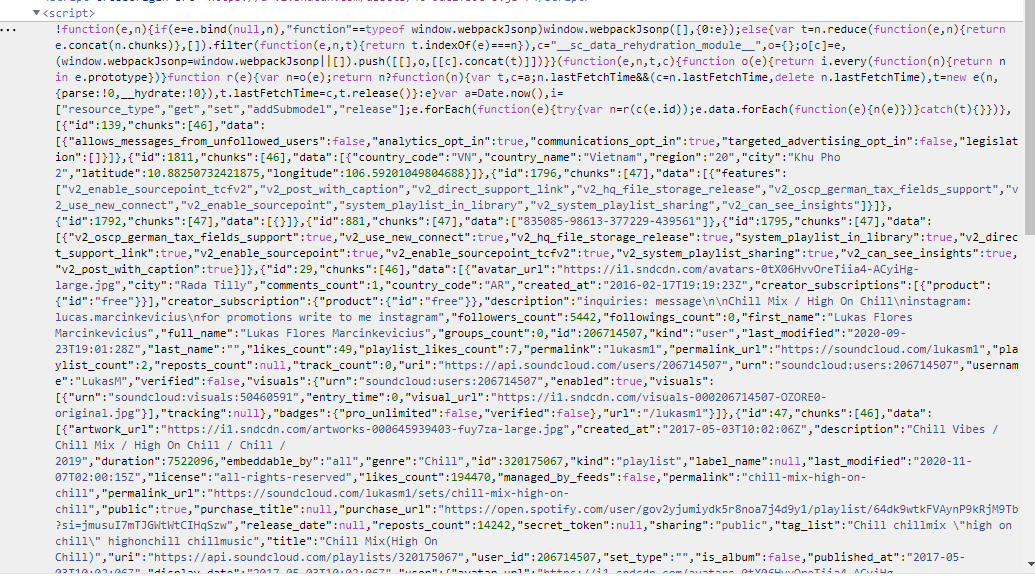

ở thẻ script cuối cùng được trả về từ Soundcloud sẽ chứa các thông tin về playlist này.

In [3]:
def get_raw_data(session,link):   
    r = session.get(link)
    x  = json.loads(r.html.xpath("/html/body/script[last()]",first=True).text[775:-2])
    return x[-1]['data'][0]

### 3. Function get_all_tracks_in_playlist:
<br>  Với một playlist bất kỳ, `get_all_tracks_in_playlist` sẽ trả về 1 danh sách link các track có trong playlist đó.
<br> SoundCloud hoạt động với cơ chế lazy loading nên để có thể lấy được danh sách các link track có trong playlist ta cần phải cuộn trình duyệt web xuống để trang hiện ra tất cả cấc bài hát. Hàm  `get_all_tracks` - đầu tiên sẽ lấy thông tin về tổng số bài hát có trong playlist đó sau đó sẽ sử dụng selenium để cuộn trang web xuống cho đến khi thu thập đủ số lượng tracks có trong playlist đó.

In [4]:
def get_all_tracks_in_playlist(driver,link_playlist):
    driver.get(link_playlist)  
    soup = BeautifulSoup(driver.page_source,'html.parser')   
    script = soup.body.script
    while script.text[:14] != '!function(e,n)':
        script = script.find_next_sibling('script')
    raw_data = script.text[775:-2]
    num_tracks = len(json.loads(raw_data)[-1]['data'][0]['tracks'])
    tracks = driver.find_elements_by_class_name("trackList__item.sc-border-light-bottom") 
    count = len(tracks)
    while count < num_tracks:    
        driver.find_element_by_tag_name('body').send_keys(Keys.PAGE_DOWN)
        tracks = driver.find_elements_by_class_name("trackList__item.sc-border-light-bottom") 
        count = len(tracks)
    while True :
        links = []    
        for track in driver.find_elements_by_class_name("trackItem__trackTitle.sc-link-dark.sc-font-light") :
            link = track.get_attribute('href')
            links.append(link[0:link.find("?in=")])
        if len(links) == num_tracks:
            break
        
    return links

### 4. Function get_allplaylist:
<br> Để có thể thu thập dữ liệu ở Soundcloud để phục vụ cho việc phân tích ta sẽ thu thậ dữ liệu ở trang [cover](http://soundclound.com/discover) trên Soundcloud. 
<br><br>
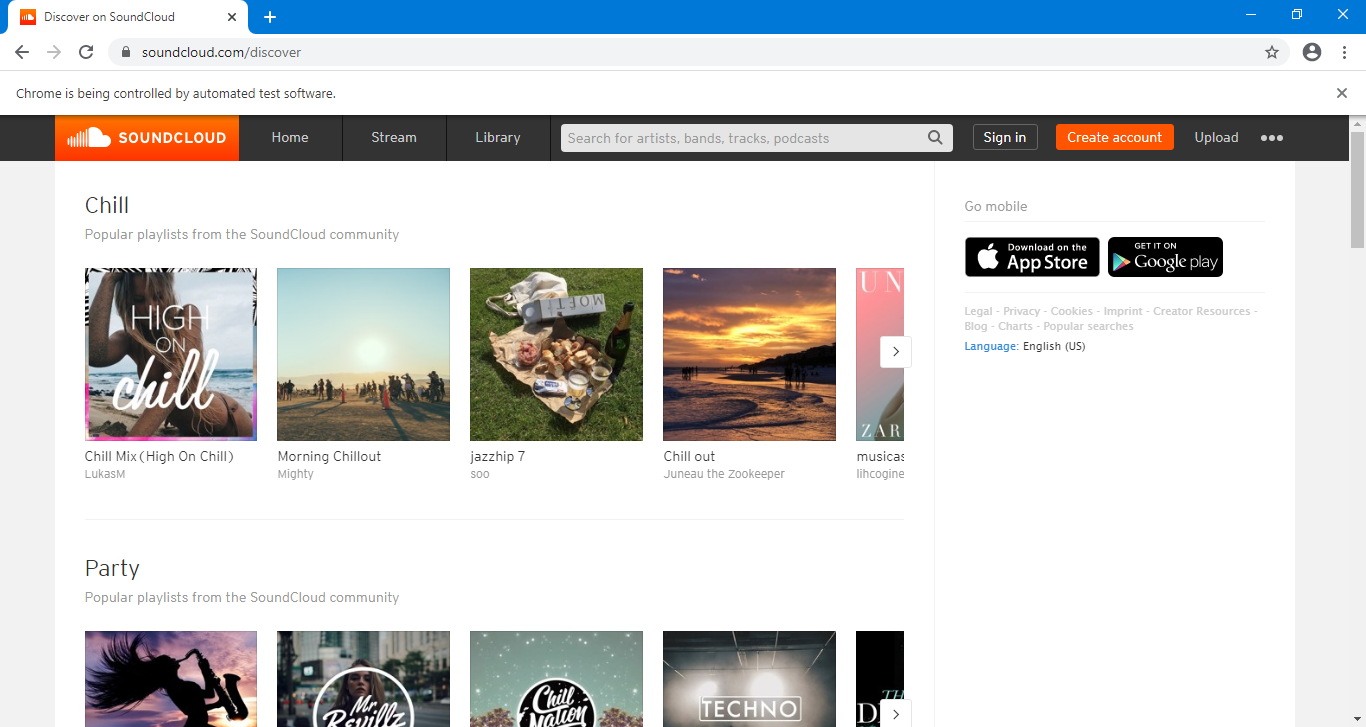
<br> Ở trang này sẽ có danh sách các playlist khấc nhau với các chủ đề khác nhau. Ta sẽ thu thập dữ liệu ở các playlist này bao gồm danh sách bài hất và người publish playlist đó, với mỗi bài hát cũng sẽ thu thập dữ liệu của bài đó cùng với dữ liệu về artist đăng bài đó lên SoundCloud

In [5]:
def get_all_playlist(driver):
    link = 'https://soundcloud.com/discover'
    driver.get(link)
   
    btns = driver.find_elements_by_class_name("tileGallery__sliderButton.tileGallery__slideForwardButton.sc-button.sc-button-small.sc-button-icon")
    while(len(btns)==0):
        btns = driver.find_elements_by_class_name("tileGallery__sliderButton.tileGallery__slideForwardButton.sc-button.sc-button-small.sc-button-icon")
    for btn in btns:
        actions = ActionChains(driver)
        actions.move_to_element(btn).perform()
        while btn.is_displayed():
            btn.click()
    playlists = driver.find_elements_by_class_name('sc-link-dark.sc-type-light.playableTile__mainHeading.audibleTile__mainHeading.playableTile__heading.playableTile__audibleHeading.audibleTile__audibleHeading.sc-truncate.sc-font-light')
    links_playlist = []
    for playlist in playlists:    
        links_playlist.append(playlist.get_attribute('href'))
    return links_playlist

### 5. Function crawl_data:
từ trang [Discover]() trên soundcloud page, ta sẽ thu thập tất cả các links track từ những playlist đó và lưu vào file `links_tracks.txt`

In [6]:
def crawl_data():
    links_playlist = get_all_playlist(driver)    
    count = 0
    for playlist in links_playlist:
        link_all_tracks = get_all_tracks_in_playlist(driver,playlist)
        with open('links_tracks.txt', 'a+') as f:
            for track in link_all_tracks:
                f.write(f'{track}\n')
        count += len(link_all_tracks)
        print(count)
crawl_data()

### 6. Scrape data on Soundcloud

In [7]:
def write_to_file(file,data):
    with open(file, 'a+',encoding='utf-8') as csvfile:
        cols = list(data.keys())
        writer = csv.DictWriter(csvfile, fieldnames=cols)       
        writer.writerow(data)

In [8]:
playlist_urls = 'links_playlist.txt'
def Scrape_Playlist_Data(playlist_urls):
    links_playlist = []
    with open(playlist_urls) as f:
        links_playlist = f.readlines()
    session = HTMLSession()
    for playlist in links_playlist:
        playlist_data = get_raw_data(session, playlist[:-1])
        user_data = playlist_data.pop('user')  
        # only extract id of tracks in columns tracks
        id = [x['id'] for x in playlist_data['tracks']]
        playlist_data['tracks'] = id
        write_to_file('playlists.csv',playlist_data)
        write_to_file('users.csv',user_data)
Scrape_Playlist_Data(playlist_urls)

In [9]:

track_urls = 'links_tracks.txt'
def Scrape_track_Data(track_urls):
    links_track = []
    with open(track_urls) as f:
        links_track = f.readlines()
    session = HTMLSession()
    for track in links_track:
        track_data = get_raw_data(session, track[:-1])
        user_data = track_data.pop('user')
        write_to_file('users.csv',user_data)
        write_to_file('trckss.csv',track_data)
Scrape_track_Data(track_urls)

## II. Explore Data Analysis

### 1. Read data 

In [12]:
session = HTMLSession()
track_urls = 'links_playlist.txt'
with open(playlist_urls) as f:
        links_playlist = f.readlines()
data = get_raw_data(session,links_playlist[0][:-1])
user_data = data.pop('user')
playlist_df = pd.read_csv("playlists.csv",header = None)
playlist_df.columns = list(data.keys())
playlist_df.head()

,artwork_url,created_at,description,duration,embeddable_by,genre,id,kind,label_name,last_modified,...,title,uri,user_id,set_type,is_album,published_at,display_date,tracks,track_count,url
0,https://i1.sndcdn.com/artworks-000405464955-n4...,2015-07-23T14:35:27Z,NaN,36466443,all,chill,127755258,playlist,NaN,2020-10-29T14:23:59Z,...,Morning Chillout,https://api.soundcloud.com/playlists/127755258,2182746,NaN,False,2020-06-30T15:25:37Z,2020-06-30T15:25:37Z,"[206559958, 455663940, 656385386, 169155349, 5...",98,/mightyj-1/sets/morning-chillout
1,https://i1.sndcdn.com/artworks-000361848372-jf...,2016-01-31T15:47:19Z,"Hi Guy!!. I'm from Vietnam, hope you enjoy wit...",9116620,all,NaN,191427863,playlist,NaN,2020-08-11T15:10:22Z,...,Never Chill Before,https://api.soundcloud.com/playlists/191427863,78807268,NaN,False,2016-06-01T08:59:59Z,2016-06-01T08:59:59Z,"[97287230, 238944090, 219053483, 206060985, 19...",38,/bi-s-n-3/sets/chilloutwithme
2,https://i1.sndcdn.com/artworks-000104728925-im...,2015-01-27T10:43:18Z,The Last Chillstep Playlist You'll Ever Need p...,24528455,all,Chillstep,75666326,playlist,NaN,2015-02-25T20:42:51Z,...,The Last Chillstep Playlist You'll Ever Need (...,https://api.soundcloud.com/playlists/75666326,44265115,NaN,False,NaN,2015-01-27T10:43:18Z,"[108982623, 117632631, 99332370, 105772193, 15...",76,/adrien-brunelat/sets/last-chillstep-playlist
3,https://i1.sndcdn.com/artworks-000497390646-w8...,2019-02-22T12:11:08Z,NaN,9063542,all,NaN,714580602,playlist,NaN,2020-01-19T22:49:06Z,...,jazzhip 7,https://api.soundcloud.com/playlists/714580602,283347384,NaN,False,2019-03-02T03:51:24Z,2019-03-02T03:51:24Z,"[465705123, 427416225, 462277161, 369556238, 5...",45,/yourparadis/sets/jazzhip7c
4,https://i1.sndcdn.com/artworks-000645939403-fu...,2017-05-03T10:02:06Z,Chill Vibes / Chill Mix / High On Chill / Chil...,7522096,all,Chill,320175067,playlist,NaN,2020-11-07T02:00:15Z,...,Chill Mix(High On Chill),https://api.soundcloud.com/playlists/320175067,206714507,NaN,False,2017-05-03T10:02:06Z,2017-05-03T10:02:06Z,"[208596343, 328389810, 220698613, 820259254, 2...",36,/lukasm1/sets/chill-mix-high-on-chill


In [14]:

track_urls = 'links_tracks.txt'
with open(playlist_urls) as f:
        links_tracks = f.readlines()
data = get_raw_data(session,links_tracks[0][:-1])
data.pop('user')
tracks_df = pd.read_csv("tracks.csv",header = None)
tracks_df.columns = list(data.keys())
tracks_df.head()

ValueError: Length mismatch: Expected axis has 43 elements, new values have 33 elements

In [23]:
users_df = pd.read_csv("users.csv",header = None)
users_df.columns = list(user_data.keys())
users_df.head()

,avatar_url,city,comments_count,country_code,created_at,creator_subscriptions,creator_subscription,description,followers_count,followings_count,...,permalink_url,playlist_count,reposts_count,track_count,uri,urn,username,verified,visuals,badges
0,https://i1.sndcdn.com/avatars-000323651078-ilx...,Paris,227,FR,2011-12-07T19:19:59Z,[{'product': {'id': 'creator-pro-unlimited'}}],{'product': {'id': 'creator-pro-unlimited'}},- All inquiries -\r\njeanarmel@free.fr,42650,280,...,https://soundcloud.com/millesimofficial,5,NaN,19,https://api.soundcloud.com/users/9583698,soundcloud:users:9583698,Millesim,False,"{'urn': 'soundcloud:users:9583698', 'enabled':...","{'pro_unlimited': True, 'verified': False}"
1,https://i1.sndcdn.com/avatars-000581924721-s6m...,"Chicago, IL",464,NaN,2012-02-15T15:15:29Z,[{'product': {'id': 'creator-pro-unlimited'}}],{'product': {'id': 'creator-pro-unlimited'}},---------------Aash Mehta---------------\r\n\r...,12949,769,...,https://soundcloud.com/aash-mehta,11,NaN,45,https://api.soundcloud.com/users/12133683,soundcloud:users:12133683,Aash Mehta,False,"{'urn': 'soundcloud:users:12133683', 'enabled'...","{'pro_unlimited': True, 'verified': False}"
2,https://i1.sndcdn.com/avatars-000365705150-a8m...,Breda,17,NL,2009-10-05T12:18:59Z,[{'product': {'id': 'free'}}],{'product': {'id': 'free'}},A superstar Dutch DJ who helped shape the EDM ...,1909521,8,...,https://soundcloud.com/hardwell,100,NaN,576,https://api.soundcloud.com/users/296190,soundcloud:users:296190,HARDWELL,False,"{'urn': 'soundcloud:users:296190', 'enabled': ...","{'pro_unlimited': False, 'verified': False}"
3,https://i1.sndcdn.com/avatars-4JYuYWd0hmW0jzCa...,World,11,NaN,2014-04-23T00:14:51Z,[{'product': {'id': 'creator-pro-unlimited'}}],{'product': {'id': 'creator-pro-unlimited'}},We are Hegemon. \r\n\r\nSubmit Music: https://...,251850,16,...,https://soundcloud.com/hegemon,7,NaN,146,https://api.soundcloud.com/users/90856694,soundcloud:users:90856694,Hegemon Select,False,"{'urn': 'soundcloud:users:90856694', 'enabled'...","{'pro_unlimited': True, 'verified': False}"
4,https://i1.sndcdn.com/avatars-hNi8wz9wN24NRNAZ...,Amsterdam,87,NL,2012-11-22T20:33:02Z,[{'product': {'id': 'creator-pro-unlimited'}}],{'product': {'id': 'creator-pro-unlimited'}},Listen to brand new releases in the Armada Mus...,290272,104,...,https://soundcloud.com/armadamusic,1080,NaN,2173,https://api.soundcloud.com/users/28884239,soundcloud:users:28884239,Armada Music,False,"{'urn': 'soundcloud:users:28884239', 'enabled'...","{'pro_unlimited': True, 'verified': False}"


### 2. Understanding Data

#### a. Playlist

-  Kiểm tra kiểu dữ liệu ở các cột


In [227]:
playlist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artwork_url       257 non-null    object 
 1   created_at        299 non-null    object 
 2   description       130 non-null    object 
 3   duration          299 non-null    int64  
 4   embeddable_by     299 non-null    object 
 5   genre             211 non-null    object 
 6   id                299 non-null    int64  
 7   kind              299 non-null    object 
 8   label_name        0 non-null      float64
 9   last_modified     299 non-null    object 
 10  license           299 non-null    object 
 11  likes_count       299 non-null    int64  
 12  managed_by_feeds  299 non-null    bool   
 13  permalink         299 non-null    object 
 14  permalink_url     299 non-null    object 
 15  public            299 non-null    bool   
 16  purchase_title    13 non-null     object 
 1

 - Kiểm tra các trường bị thiếu 


In [228]:
playlist_df.isnull().sum().sort_values(ascending = False).head()

secret_token      299
label_name        299
set_type          293
purchase_title    286
purchase_url      284
dtype: int64

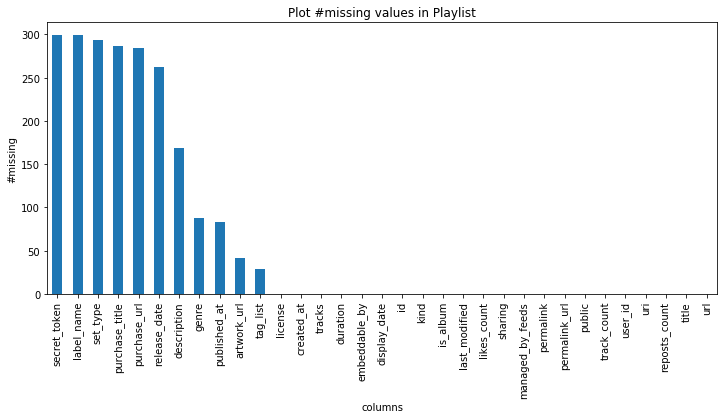

In [229]:
playlist_df.isnull().sum().sort_values(ascending = False).plot(kind = 'bar',figsize = (12,5))
plt.xlabel("columns")
plt.ylabel("#missing")
plt.title("Plot #missing values in Playlist");

-  Kiểm tra trùng lắp dữ liệu trùng lắp

In [230]:
playlist_duplicate = playlist_df.duplicated()
print("Số lượng dữ liệu user bị trùng là: ",playlist_duplicate.sum())

Số lượng dữ liệu user bị trùng là:  82


- Xóa các dòng bị trùng lắp

In [231]:
playlist_df.drop_duplicates(inplace=True)

-  Kiểm tra phân bố của dữ liệu:

In [232]:
playlist_df.describe()

,duration,id,label_name,likes_count,reposts_count,secret_token,user_id,track_count
count,2.170000e+02,2.170000e+02,0.0,217.000000,217.000000,0.0,2.170000e+02,217.000000
mean,1.089493e+07,3.782672e+08,NaN,35306.304147,2301.622120,NaN,1.667324e+08,35.557604
std,1.155224e+07,2.561161e+08,NaN,44748.290329,3144.551847,NaN,1.357128e+08,28.759985
min,1.937826e+06,1.415256e+07,NaN,275.000000,9.000000,NaN,4.450630e+05,7.000000
25%,4.176504e+06,1.970214e+08,NaN,5013.000000,278.000000,NaN,7.644563e+07,16.000000
50%,7.522096e+06,3.092181e+08,NaN,14204.000000,861.000000,NaN,1.334671e+08,26.000000
75%,1.401583e+07,5.811419e+08,NaN,51269.000000,3479.000000,NaN,2.142799e+08,45.000000
max,1.295970e+08,1.132958e+09,NaN,238195.000000,20033.000000,NaN,8.492170e+08,182.000000


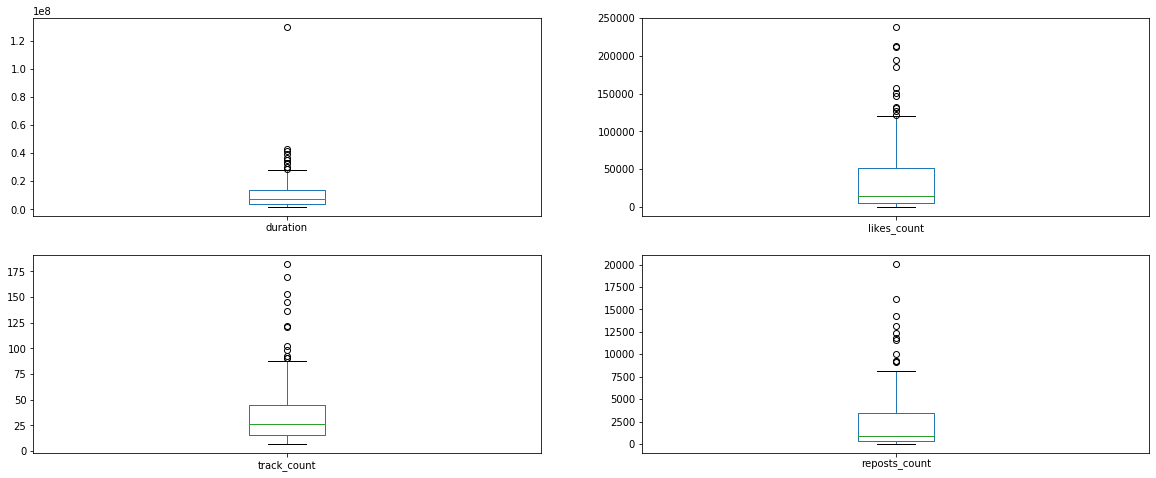

In [233]:
fig,axs = plt.subplots(2,2,figsize = (20,8))
playlist_df.duration.plot(kind='box',ax = axs[0,0])
playlist_df.likes_count.plot(kind='box',ax= axs[0,1])
playlist_df.reposts_count.plot(kind='box',ax=axs[1,1])
playlist_df.track_count.plot(kind='box',ax=axs[1,0])



#### b. Tracks

-  Kiểm tra kiểu dữ liệu ở các cột


In [31]:
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11080 entries, 0 to 11079
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   artwork_url         10519 non-null  object 
 1   caption             19 non-null     object 
 2   commentable         11080 non-null  bool   
 3   comment_count       11005 non-null  float64
 4   created_at          11080 non-null  object 
 5   description         8377 non-null   object 
 6   downloadable        11080 non-null  bool   
 7   download_count      11021 non-null  float64
 8   duration            11080 non-null  int64  
 9   full_duration       11080 non-null  int64  
 10  embeddable_by       11080 non-null  object 
 11  genre               9726 non-null   object 
 12  has_downloads_left  11080 non-null  bool   
 13  id                  11080 non-null  int64  
 14  kind                11080 non-null  object 
 15  label_name          2203 non-null   object 
 16  last

- Kiểm tra các trường bị thiếu giá trị:

In [46]:
tracks_df.isnull().sum().sort_values(ascending = False).head()

secret_token    11080
caption         11061
visuals         10783
label_name       8877
release_date     8543
dtype: int64

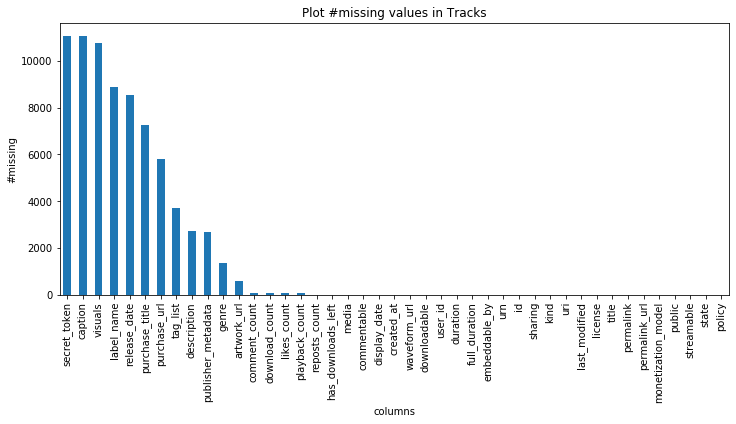

In [76]:
tracks_df.isnull().sum().sort_values(ascending = False).plot(kind = 'bar',figsize = (12,5))
plt.xlabel("columns")
plt.ylabel("#missing")
plt.title("Plot #missing values in Tracks");

-  Kiểm tra trùng lắp dữ liệu trùng lắp

In [121]:
tracks_duplicate = tracks_df.duplicated()
print("Số lượng dữ liệu tracks bị trùng là: ",tracks_duplicate.sum())

Số lượng dữ liệu tracks bị trùng là:  293


- Xóa các dòng bị trùng lắp

In [122]:
tracks_df.drop_duplicates(inplace=True)

-  Kiểm tra phân bố của dữ liệu:

In [123]:
tracks_df.describe()

,comment_count,download_count,duration,full_duration,id,likes_count,playback_count,reposts_count,secret_token,user_id
count,10735.000000,1.075100e+04,1.078700e+04,1.078700e+04,1.078700e+04,1.075100e+04,1.075100e+04,10787.000000,0.0,1.078700e+04
mean,792.569446,2.432374e+03,2.749429e+05,2.814642e+05,2.974574e+08,6.332729e+04,4.189152e+06,6639.855660,NaN,9.111641e+07
std,2815.250046,2.876290e+04,5.809517e+05,5.794305e+05,2.014107e+08,1.850113e+05,1.295454e+07,19068.523389,NaN,1.309530e+08
min,0.000000,0.000000e+00,1.510000e+04,1.510000e+04,5.606600e+04,7.000000e+00,1.700000e+02,0.000000,NaN,2.150000e+02
25%,37.000000,0.000000e+00,1.670990e+05,1.733505e+05,1.697353e+08,2.586000e+03,1.931260e+05,146.000000,NaN,4.497460e+06
50%,125.000000,0.000000e+00,2.092600e+05,2.117490e+05,2.555290e+08,8.816000e+03,6.311910e+05,683.000000,NaN,3.393919e+07
75%,482.500000,0.000000e+00,2.570950e+05,2.594065e+05,3.459165e+08,3.908400e+04,2.524828e+06,4257.500000,NaN,1.346832e+08
max,151126.000000,1.398165e+06,2.328776e+07,2.328776e+07,9.228485e+08,2.979536e+06,2.147224e+08,295770.000000,NaN,8.983582e+08


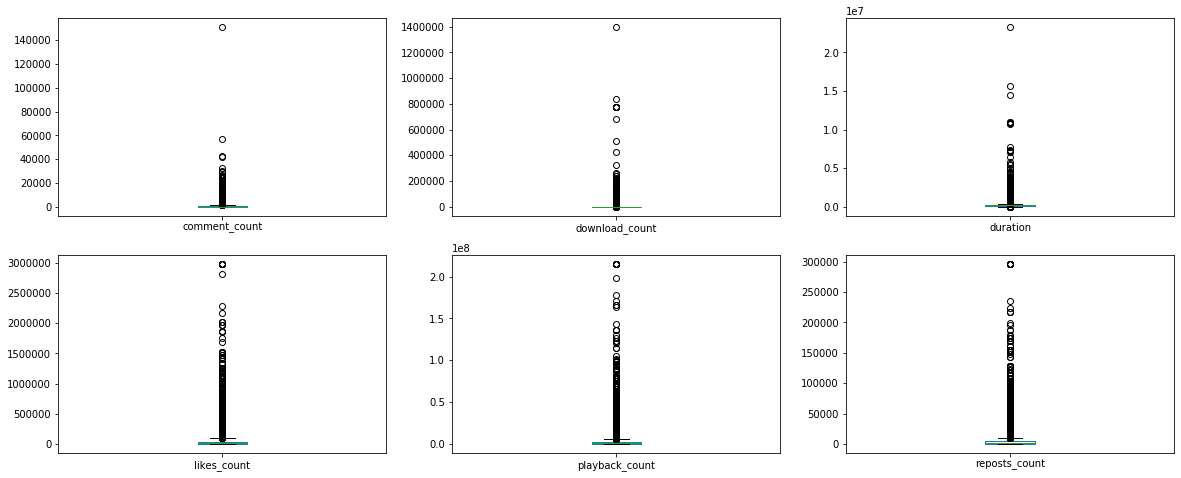

In [124]:
fig,axs = plt.subplots(2,3,figsize = (20,8))
tracks_df.comment_count.plot(kind='box',ax = axs[0,0])
tracks_df.download_count.plot(kind='box',ax= axs[0,1])
tracks_df.duration.plot(kind='box',ax=axs[0,2])
tracks_df.likes_count.plot(kind='box',ax=axs[1,0])
tracks_df.playback_count.plot(kind='box',ax=axs[1,1])
tracks_df.reposts_count.plot(kind='box',ax =axs[1,2])


#### c. Users

-  Kiểm tra kiểu dữ liệu ở các cột


In [30]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11380 entries, 0 to 11379
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   avatar_url             11380 non-null  object 
 1   city                   7537 non-null   object 
 2   comments_count         11380 non-null  int64  
 3   country_code           5746 non-null   object 
 4   created_at             11380 non-null  object 
 5   creator_subscriptions  11380 non-null  object 
 6   creator_subscription   11380 non-null  object 
 7   description            8934 non-null   object 
 8   followers_count        11380 non-null  int64  
 9   followings_count       11380 non-null  int64  
 10  first_name             5792 non-null   object 
 11  full_name              5847 non-null   object 
 12  groups_count           11380 non-null  int64  
 13  id                     11380 non-null  int64  
 14  kind                   11380 non-null  object 
 15  la

- Kiểm tra giá trị bị thiếu:

In [73]:
users_df.isnull().sum().sort_values(ascending = False).head()

reposts_count    11380
last_name         7340
country_code      5634
first_name        5588
full_name         5533
dtype: int64

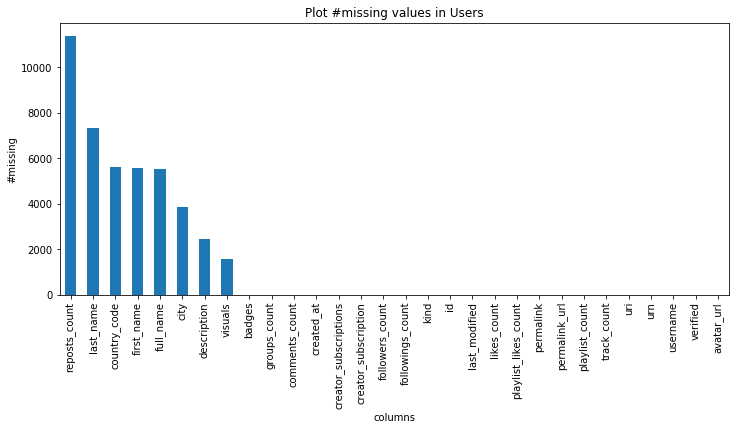

In [75]:
users_df.isnull().sum().sort_values(ascending = False).plot(kind = 'bar',figsize = (12,5))
plt.xlabel("columns")
plt.ylabel("#missing")
plt.title("Plot #missing values in Users");

-  Kiểm tra trùng lắp dữ liệu trùng lắp

In [88]:
user_duplicate = users_df.duplicated()
print("Số lượng dữ liệu user bị trùng là: ",user_duplicate.sum())

Số lượng dữ liệu user bị trùng là:  5654


- Xóa các dòng bị trùng lắp

In [90]:
users_df.drop_duplicates(inplace=True)

-  Kiểm tra phân bố của dữ liệu:

In [112]:
users_df.describe()

,comments_count,followers_count,followings_count,groups_count,id,likes_count,playlist_likes_count,playlist_count,reposts_count,track_count
count,5726.000000,5.726000e+03,5726.000000,5726.0,5.726000e+03,5726.000000,5726.000000,5726.000000,0.0,5726.000000
mean,261.619979,2.021198e+05,217.012924,0.0,9.253903e+07,597.536675,25.986902,16.603213,NaN,114.272092
std,1679.883615,8.349277e+05,361.050998,0.0,1.289224e+08,1600.735220,180.726062,57.434856,NaN,348.421439
min,0.000000,0.000000e+00,0.000000,0.0,2.150000e+02,0.000000,0.000000,0.000000,NaN,0.000000
25%,1.000000,6.082500e+02,8.000000,0.0,5.250416e+06,13.000000,0.000000,1.000000,NaN,11.000000
50%,20.000000,5.962500e+03,65.000000,0.0,3.777032e+07,111.000000,4.000000,4.000000,NaN,31.000000
75%,146.000000,5.754225e+04,265.000000,0.0,1.359937e+08,558.000000,17.000000,13.000000,NaN,81.000000
max,89609.000000,9.870587e+06,2010.000000,0.0,8.983582e+08,45799.000000,8899.000000,1385.000000,NaN,5111.000000


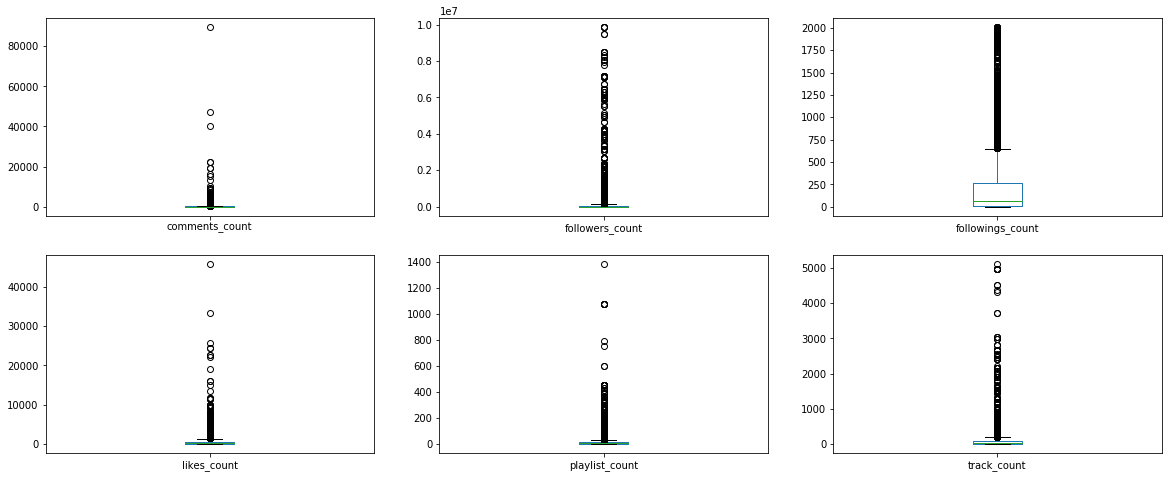

In [110]:
fig,axs = plt.subplots(2,3,figsize = (20,8))
users_df.comments_count.plot(kind='box',ax = axs[0,0])
users_df.followers_count.plot(kind='box',ax= axs[0,1])
users_df.followings_count.plot(kind='box',ax=axs[0,2])
users_df.likes_count.plot(kind='box',ax=axs[1,0])
users_df.playlist_count.plot(kind='box',ax=axs[1,1])
users_df.track_count.plot(kind='box',ax =axs[1,2])


### 3. Analysis Data

#### a. Những thể loại nhạc nào được nghe nhiều nhất ?
<br> SoundCloud cung cấp một platform nghe nhạc trực tuyến trên hơn 76 ngàn user với số lượng bài nhạc được tăng tải vô cùng khổng lồ. Với lượng dữ liệu về các bài hát ta thu thập được ta sẽ tìm ra top 10 thể loại được nghe nhiều nhất trên Soundcloud. Từ đó biết được xu hướng thị trường âm nhạc hiện nay trên SoundCloud.

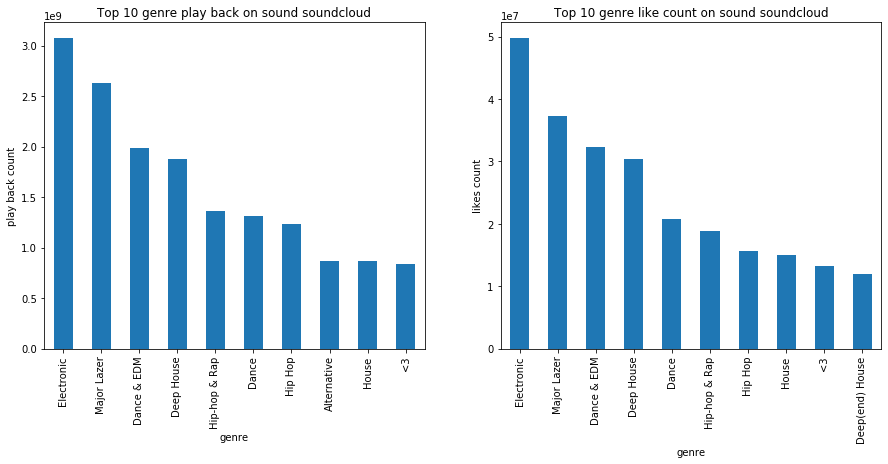

In [254]:
fig, axs = plt.subplots(1,2,figsize =(15,6))
tracks_df.groupby("genre").agg('sum')['playback_count'].sort_values(ascending =False)[:10].plot(kind='bar',ax = axs[0])
axs[0].set_ylabel('play back count')
axs[0].set_title("Top 10 genre play back on sound soundcloud")

tracks_df.groupby("genre").agg('sum')['likes_count'].sort_values(ascending =False)[:10].plot(kind='bar',ax= axs[1])
axs[1].set_ylabel('likes count')
axs[1].set_title("Top 10 genre like count on sound soundcloud");

$\implies$Ta có thể thấy dễ dàng rằng thể loại nhạc điện tử đang được quan tâm rất nhiều trên soundcloud.

#### b. Người dùng Soundcloud đến từ những thành phố nào ?
<br> Soundcloud có số lượng người dùng rất lớn và có phân bố rộng khắp. Ta sẽ tìm hiểu thử phân bố người dùng trên SoundCloud theo địa lý

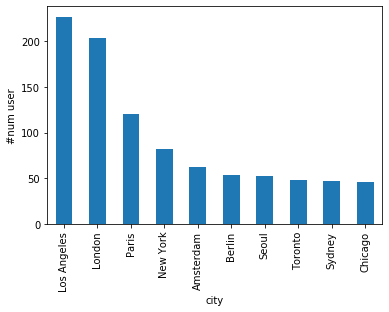

In [270]:
users_df.groupby("city").agg('count')['id'].sort_values(ascending =False)[:10].plot(kind = 'bar')
plt.ylabel("#num user");


$\implies $ Ta thấy được người dùng của SoundCloud phân bố khá rộng khi từ các thành phố lớn ở các đất nước có nền công nghiệp giải trí phát triển như Mĩ, Anh, Pháp, Hàn Quốc, Đức, và Australia, ...

##  Furture Working

- Nếu có thêm thời gian, thiết bị lưu trữ, và các hệ quản trị cơ sở dữ liệu ta có thể thu thập thêm nhiều dữ liệu hơn từ Soundcloud từ trang [directory](https://soundcloud.com/people/directory) từ soundcloud. Đây là một trang tổng hợp các thông tin từ tất cả các user của soundcloud và từ những thông tin về user ta có thể thu thập được các thông tin khác như các tracks và playlist mà họ đăng tải từ đó ta sẽ có nhiều thông tin hơn.
-  Với một lượng lớn thông tin từ soundcloud ta có thể phân tích và tìm ra nhiều insights hơn
- Dữ liệu có thể thu thập được bao gồm các các comment và các description từ các bài hát và media từ các tracks, nếu có thêm kiến thức ta có thể xây dựng một hệ thống  đánh giá cảm xúc của người nghe, đưa ra các dự đoán về sự đoán nhận của người nghe đối với một tracks từ những dự liệu đã có.

---
<div style="text-align:center">
    THANK YOU FOR READING
    
   
</div>
